In [59]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5
import scienceplots

In [2]:
# set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [3]:
sys.path.append("../../..")

In [60]:
from source.NAHEA_CNN import NAHEA_CNN_1, CNN_1D
plt.style.use(["science", "grid"])

In [5]:
# load data from sin dataset
data_save_dir = Path("../../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train_full = f["X"][:].squeeze(2)
    y_train_full = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [6]:
n_train = 150
n_val = 250 # validation is much faster than training
n_test = 500 # testing is much faster than training
X_train = X_train_full[:n_train]
y_train = y_train_full[:n_train]
X_val = X_train_full[n_train:n_train+n_val]
y_val = y_train_full[n_train:n_train+n_val]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

seq_len = X_train.shape[1]

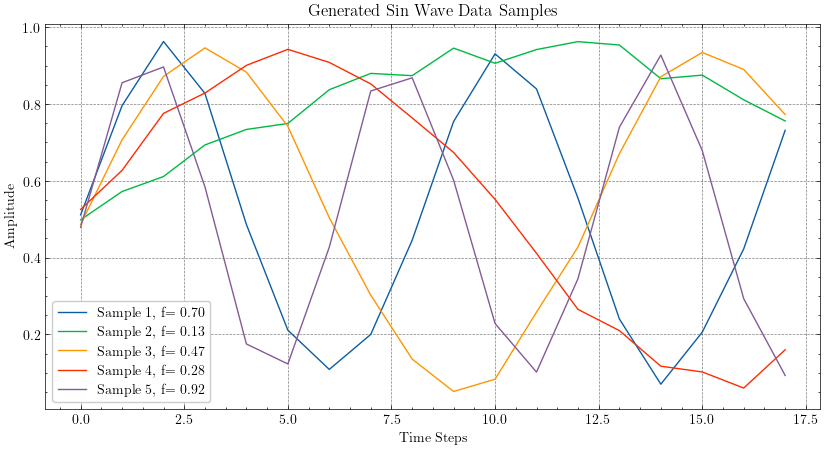

In [61]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [8]:
y_val = torch.tensor(y_val, dtype=torch.float64)
if len(y_val.shape) == 2:
    y_val = y_val.squeeze(1)


In [9]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 4),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 5,
}

batch_size = 16
epochs = 50

In [21]:
# device = torch.device("cuda")
device = torch.device("cpu")
data = {
    "X_train": torch.tensor(X_train, dtype=torch.float64).to(device).reshape(-1, 1, seq_len),
    "y_train": torch.tensor(y_train, dtype=torch.float64).to(device),
    "X_val": torch.tensor(X_val, dtype=torch.float64).to(device).reshape(-1, 1, seq_len),
    "y_val": torch.tensor(y_val, dtype=torch.float64).to(device),
    "X_test": torch.tensor(X_test, dtype=torch.float64).to(device).reshape(-1, 1, seq_len),
    "y_test": torch.tensor(y_test, dtype=torch.float64).to(device),
}

/tmp/ipykernel_357291/3324764425.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "y_val": torch.tensor(y_val, dtype=torch.float64).to(device),


In [22]:
def train_and_test_CNN_classical(epochs: int, data: dict, np_seed: int = 42, torch_seed = None, device = torch.device("cpu")):
    if torch_seed is None:
        torch_seed = np_seed
    np.random.seed(np_seed)
    torch.manual_seed(torch_seed)
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_val = data["X_val"]
    y_val = data["y_val"]
    X_test = data["X_test"]
    y_test = data["y_test"]

    CNN_classical = CNN_1D(hparams=hparams)
    CNN_classical = CNN_classical.double().to(device)  # move model to device

    # train the model
    loss_hist = []
    loss_hist_val = []
    loss_fn = torch.nn.MSELoss()
    CNN_classical.train()
    optimizer = torch.optim.Adam(
        CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
    )
    for epoch in range(epochs):
        CNN_classical.train()
        # shuffle X_train and y_train
        idxs = np.arange(len(X_train))
        idxs = np.random.permutation(idxs)
        X_train = X_train[idxs]
        y_train = y_train[idxs]

        epoch_losses = []
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            x_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size].to(torch.float64).squeeze(1)
            batch_out = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
            predicted = batch_out
            loss = loss_fn(predicted.squeeze(1), y_batch)
            epoch_losses.append(loss.item())
            loss_hist.append(loss.item())
            loss.backward()
            optimizer.step()
        epoch_loss = np.mean(epoch_losses)

        # validation
        CNN_classical.eval()
        with torch.no_grad():
            val_out = CNN_classical(X_val)
            val_loss = loss_fn(val_out.squeeze(1), y_val)
            loss_hist_val.append(val_loss.item())

    loss_hist = np.array(loss_hist)

    # testing
    CNN_classical.eval()
    with torch.no_grad():
        predicted = CNN_classical(X_test).squeeze(1)  # (batch_size, 1, seq_len)
        test_loss = loss_fn(predicted, y_test.squeeze(1))

    out = {
        "test_loss": test_loss.item(),
        "test_loss_rmse": np.sqrt(test_loss.item()),
        "train_history_rmse": np.sqrt(loss_hist),
        "val_history_rmse": np.sqrt(loss_hist_val),
        "hparams": hparams,
        "model_state_dict": CNN_classical.state_dict(),
    }

    return out

In [23]:
import time
out_dicts = {}
t_old = time.time()
n_tries = 5000
for np_seed in tqdm(range(n_tries)):
    out = train_and_test_CNN_classical(epochs=epochs, data=data, np_seed=np_seed, device=device)
    out_dicts[np_seed] = out
test_losses_rmse = [out["test_loss_rmse"] for out in out_dicts.values()]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [48]:
losses_path = Path("losses_hist") / "sin" / "CNN_Classical_sin_RndSeedSweep.pickle"
losses_path.parent.mkdir(parents=True, exist_ok=True)
import pickle
with open(losses_path, "wb") as f:
    pickle.dump(out_dicts, f)

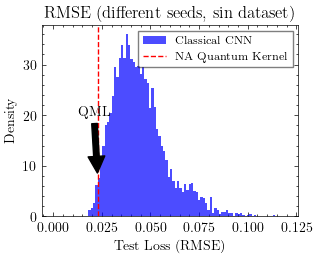

In [79]:
test_losses_rmse = [out["test_loss_rmse"] for out in out_dicts.values()]
# plot histogram of test losses
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
plt.hist(test_losses_rmse, bins=100, density=True, alpha=0.7, color='blue', range=(0, 0.12), label='Classical CNN')
x_qml = 0.0228
# vertical line and arrow at x_qml
plt.axvline(x=x_qml, color='red', linestyle='--', label='NA Quantum Kernel')
plt.annotate('QML', xy=(x_qml, 8), xytext=(x_qml - 0.01, 20),
             arrowprops=dict(facecolor='black', shrink=0.05))
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
plt.title("RMSE (different seeds, sin dataset)")
plt.xlabel("Test Loss (RMSE)")
plt.ylabel("Density")
plt.grid()
plot_path = Path("figures") / "sin" / "CNN_Classical_sin_RndSeedSweep.png"
plot_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight', dpi=300)
plt.show()

In [51]:
# What percentage of the losses are above the QML loss?
percentage_above_qml = np.mean(np.array(test_losses_rmse) > x_qml) * 100
print(f"Percentage of losses above QML loss: {percentage_above_qml:.2f}%")

Percentage of losses above QML loss: 98.62%


# With Learned Channel Collapse

In [46]:
from source.NAHEA_CNN import CNN_1D_Learned_Channel_Collapse

In [ ]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 4),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 4,
}


In [47]:
def train_and_test_CNN_classical_w_learned_ch_collapse(epochs: int, data: dict, np_seed: int = 42, torch_seed = None, device = torch.device("cpu")):
    if torch_seed is None:
        torch_seed = np_seed
    np.random.seed(np_seed)
    torch.manual_seed(torch_seed)
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_val = data["X_val"]
    y_val = data["y_val"]
    X_test = data["X_test"]
    y_test = data["y_test"]

    CNN_classical = CNN_1D_Learned_Channel_Collapse(hparams=hparams)
    CNN_classical = CNN_classical.double().to(device)

    # train the model
    loss_hist = []
    loss_hist_val = []
    loss_fn = torch.nn.MSELoss()
    CNN_classical.train()
    optimizer = torch.optim.Adam(
        CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
    )
    for epoch in range(epochs):
        CNN_classical.train()
        # shuffle X_train and y_train
        idxs = np.arange(len(X_train))
        idxs = np.random.permutation(idxs)
        X_train = X_train[idxs]
        y_train = y_train[idxs]

        epoch_losses = []
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            x_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size].to(torch.float64).squeeze(1)
            batch_out = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
            predicted = batch_out
            loss = loss_fn(predicted.squeeze(1), y_batch)
            epoch_losses.append(loss.item())
            loss_hist.append(loss.item())
            loss.backward()
            optimizer.step()
        epoch_loss = np.mean(epoch_losses)

        # validation
        CNN_classical.eval()
        with torch.no_grad():
            val_out = CNN_classical(X_val)
            val_loss = loss_fn(val_out.squeeze(1), y_val)
            loss_hist_val.append(val_loss.item())

    loss_hist = np.array(loss_hist)

    # testing
    CNN_classical.eval()
    with torch.no_grad():
        predicted = CNN_classical(X_test).squeeze(1)  # (batch_size, 1, seq_len)
        test_loss = loss_fn(predicted, y_test.squeeze(1))

    out = {
        "test_loss": test_loss.item(),
        "test_loss_rmse": np.sqrt(test_loss.item()),
        "train_history_rmse": np.sqrt(loss_hist),
        "val_history_rmse": np.sqrt(loss_hist_val),
        "hparams": hparams,
        "model_state_dict": CNN_classical.state_dict(),
    }

    return out

In [49]:
out_dicts_2 = {}
t_old = time.time()
n_tries = 5000
for np_seed in tqdm(range(n_tries)):
    out = train_and_test_CNN_classical_w_learned_ch_collapse(epochs=epochs, data=data, np_seed=np_seed, device=device)
    out_dicts_2[np_seed] = out
test_losses_rmse_2 = [out["test_loss_rmse"] for out in out_dicts_2.values()]

  0%|          | 0/5000 [00:00<?, ?it/s]

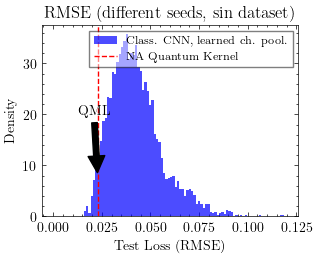

In [78]:
# plot histogram of test losses
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
plt.hist(test_losses_rmse_2, bins=100, density=True, alpha=0.7, color='blue', range=(0, 0.12), label='Class. CNN, learned ch. pool.')
# plt.hist(test_losses_rmse_2, bins=100, density=True, alpha=0.7, color='blue', range=(0, 0.12), label='Classical CNN')
x_qml = 0.0228
plt.axvline(x=x_qml, color='red', linestyle='--', label='NA Quantum Kernel')
plt.annotate('QML', xy=(x_qml, 8), xytext=(x_qml - 0.01, 20),
             arrowprops=dict(facecolor='black', shrink=0.05))
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
plt.title("RMSE (different seeds, sin dataset)")
plt.xlabel("Test Loss (RMSE)")
plt.ylabel("Density")
plt.grid()
fig_path = Path("figures") / "sin" / "CNN_Classical_sin_RndSeedSweep_learned_ch_collapse.png"
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

In [53]:
# save the losses
losses_path = Path("losses_hist") / "sin" / "CNN_Classical_sin_RndSeedSweep_learned_ch_collapse.pickle"
losses_path.parent.mkdir(parents=True, exist_ok=True)
with open(losses_path, "wb") as f:
    pickle.dump(out_dicts_2, f)

In [72]:
# how many losses are above the QML loss?
percentage_above_qml = np.mean(np.array(test_losses_rmse_2) > x_qml) * 100
print(f"Percentage of losses above QML loss: {percentage_above_qml:.2f}%")

Percentage of losses above QML loss: 96.98%
